In [1]:
# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math
import numpy as np

# Setting stylistic/helpful seaborn & matplotlib things for graphs
sns.set()
sns.set_style("white")
sns.set_palette("dark")

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

In [2]:
# Loading thie files and organising them appropriately
def loadCSV(filename, folder="MSQ_CSVs"):
    df = pd.read_csv(folder + "/" + filename + ".csv", skiprows=2, header=None)
    df = df.drop(labels=0, axis=1)
    df[1] = df[1].apply(lambda x: datetime.strptime(x, "%d/%m/%y %H:%M:%S"))
    return df.rename(columns={1: "Datetime", 2: "AC Current"})

MSQdata_1 = loadCSV("20190522_MSQ_HLH")
MSQdata_2 = loadCSV("20190904_MSQ_HLH")
MSQdata_3 = loadCSV("20191114_MSQ_HLH")

MSQdata_all = pd.concat([MSQdata_1, MSQdata_2, MSQdata_3]).reset_index(drop=True)

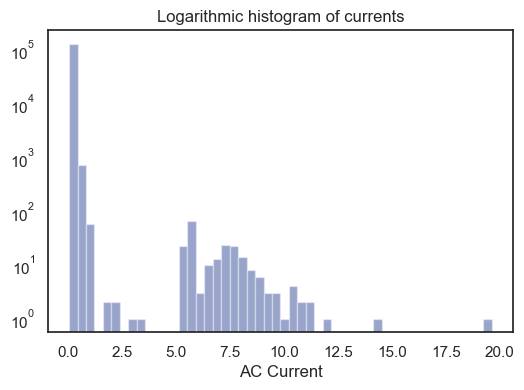

In [3]:
# First look into currents used
ax = sns.distplot(MSQdata_all["AC Current"],kde = False)
ax.set_title("Logarithmic histogram of currents")
ax.set_yscale('log')

In [4]:
# Calculating the total amount of kWh used by the system over the running period
totalKWH = MSQdata_all["AC Current"].sum()*90*240/60/60/1000

# Calculating the running period
runningPeriod = int((MSQdata_1["Datetime"].tail(1) - MSQdata_1["Datetime"][0]).astype('timedelta64[h]'))
runningPeriod += int((MSQdata_2["Datetime"].tail(1) - MSQdata_2["Datetime"][0]).astype('timedelta64[h]'))
runningPeriod += int((MSQdata_3["Datetime"].tail(1) - MSQdata_3["Datetime"][0]).astype('timedelta64[h]'))

# Calculating the average running cost
totalKWH/runningPeriod

0.029972051660516603

Assuming that a public barbeque is used for an average of half an hour of on-time a day, it will use 1.2kWh each day.
The average use of this HLH pole in MSQ shows that it uses around 0.71kWh in the same amount of time.
Around 2 of these could be implemented for similar electrical costs as a public barbeque.

Text(0.5, 1.0, 'Current usage by time of day')

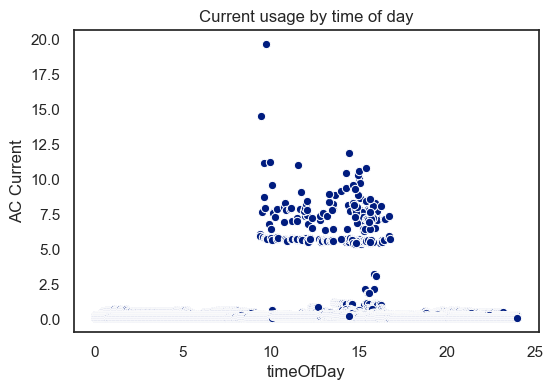

In [5]:
MSQdata_all["timeOfDay"] = MSQdata_all["Datetime"].apply(lambda x: x.hour + x.minute/60 + x.second/(60*60))
ax = sns.scatterplot(x=MSQdata_all["timeOfDay"], y=MSQdata_all["AC Current"])
ax.set_title("Current usage by time of day")
#ax.set_yscale('log')

Text(0.5, 1.0, 'Average current usage by time of day')

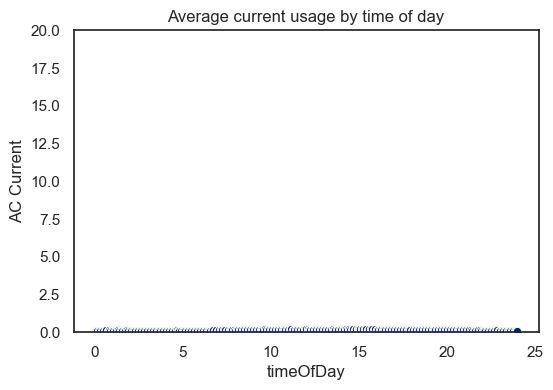

In [6]:
MSQdata_all["timeOfDayBuckets"] = MSQdata_all["timeOfDay"].apply(lambda x: round(x*12)/12)
averageData = MSQdata_all.groupby("timeOfDayBuckets").mean()

ax = sns.scatterplot(x=averageData["timeOfDay"], y=averageData["AC Current"])
ax.set(ylim=(0,20))
ax.set_title("Average current usage by time of day")
#averageData

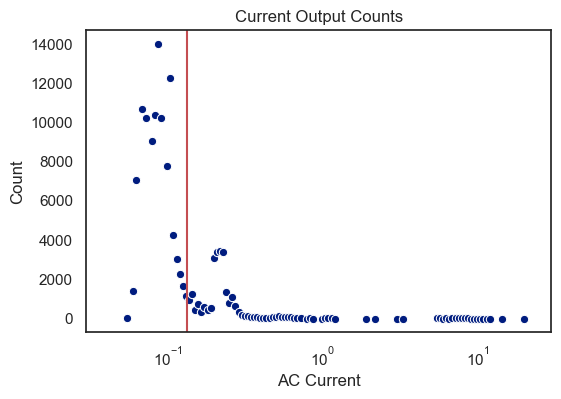

In [7]:
#This piece of code applies a logarithmic rounding to the AC Currents.
MSQdata_all["currentBuckets"] = MSQdata_all["AC Current"].apply(lambda x: math.pow(10, round(math.log([x, 0.0001][x<=0], 10)*50)/50))
currentCounts = MSQdata_all.groupby("currentBuckets").count()

ax = sns.scatterplot(x=currentCounts.index.values, y=currentCounts["AC Current"])
ax.set_title("Current Output Counts")
ax.set_xscale('log')
ax.set_ylabel("Count")
ax.set_xlabel("AC Current")
ax.set(xlim=(0.03,30))
#currentCounts
ax.axvline(x=0.135, color='r')

![20190320 MSQ set up data](20190320_MSQ_set_up_data.png)

According to the test data, all 'on' states were above 0.135 (where approximately 0.118 was the average HLH-only value) and so we can use this as the splitting point for whether the HLH was considered on or not. This has been indicated by a red vertical line on the above graph. The count values prior to this are considerably high, showing how a considerable amount of the time was spent as HLH-only.

24657 105488


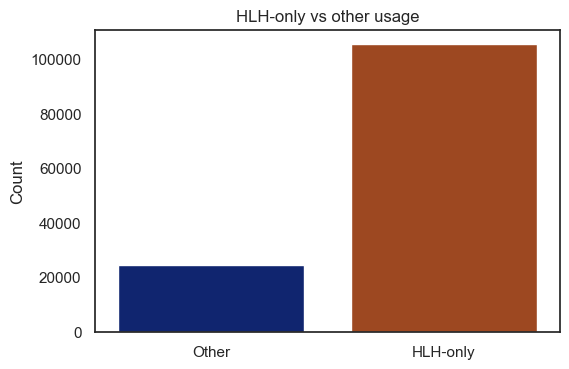

In [8]:
hlhUsed = len(MSQdata_all["AC Current"][MSQdata_all["AC Current"] > 0.135])
hlhOnly = len(MSQdata_all["AC Current"][MSQdata_all["AC Current"] < 0.135])

ax = sns.barplot(x=["Other", "HLH-only"], y=[hlhUsed, hlhOnly])
ax.set_title("HLH-only vs other usage")
ax.set_ylabel("Count")
print(hlhUsed, hlhOnly)

This shows that roughly 23.4% of the time, the hlh is being used—or roughly 5.5hrs a day.

Text(0, 0.5, 'Count')

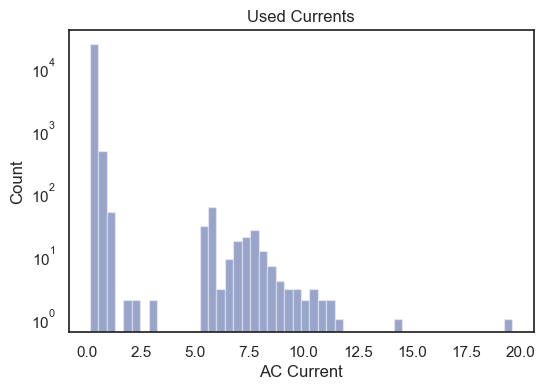

In [9]:
usedData = MSQdata_all[MSQdata_all["AC Current"] > 0.135]
ax = sns.distplot(usedData["AC Current"], kde=False)
ax.set_yscale('log')
ax.set_title("Used Currents")
ax.set_ylabel("Count")
#ax.set(ylim=(1,20))

Text(0.5, 0, 'Time of day')

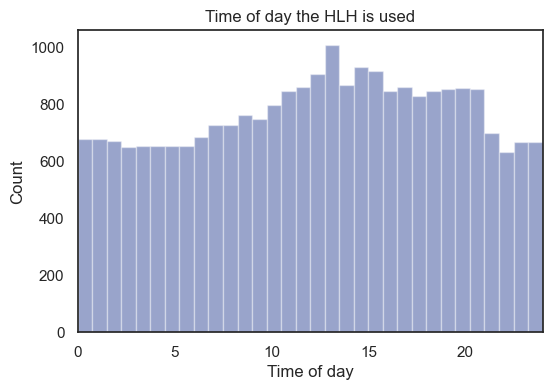

In [10]:
ax = sns.distplot(usedData["timeOfDay"], kde=False)
ax.set(xlim=(0,24))
ax.set_title("Time of day the HLH is used")
ax.set_ylabel("Count")
ax.set_xlabel("Time of day")

In [11]:
def plot_stacked_bar(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, 
                     colors=None, grid=False, reverse=False, title=None,
                     legLoc="upper left", ylim=None):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    colors          -- List of color labels
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=colors[i]))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)
        
    if ylim:
        plt.ylim(ylim)

    plt.legend(loc=legLoc, fontsize='small')
    
    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

In [12]:
usedData["timeOfDayBuckets2"] = usedData["timeOfDay"].apply(lambda x: round(x*2)/2)

def getGroupedCurrents(data, bucketsColumn="timeOfDayBuckets2", matchEnds=True):

    def groupCurrents(dfGroup):
        currents = list(dfGroup["AC Current"])
        currents.sort()
        return currents

    timeGroups = list(data.groupby(bucketsColumn).apply(groupCurrents))
    if matchEnds:
        timeGroups[0].extend(timeGroups[-1])
        timeGroups[0].sort()
        timeGroups = timeGroups[:-1]

    def roundingFunction(value):
        if value < 0.19:
            return 0.15
        elif value < 0.21:
            return 0.2
        elif value < 0.24:
            return 0.22
        elif value < 0.27:
            return 0.25
        elif value < 0.4:
            return 0.33
        elif value < 1:
            return 0.6
        elif value < 5:
            return 3
        else:
            return 12

        #logValue = 2
        #return logValue**round(math.log(value, logValue))


    allBuckets = sorted(data["AC Current"].apply(roundingFunction).unique())
    currentBucketMapper = {}
    for x in zip(allBuckets, list(range(len(allBuckets)))):
        currentBucketMapper[x[0]] = x[1]
    emptyBuckets = [0 for x in range(len(allBuckets))]


    currentBucketCounts = []
    for time in timeGroups:
        roundedCurrents = []
        for current in time:
            roundedCurrents.append(roundingFunction(current))
        currentBuckets = list(set(roundedCurrents))

        bucketCounts = emptyBuckets

        for bucket in currentBuckets:
            bucketCounts[currentBucketMapper[bucket]] = roundedCurrents.count(bucket)

        currentBucketCounts.append(list(bucketCounts))
    
    return (currentBucketCounts, allBuckets)

c:\users\baptiste\envs\smartpowerdata\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


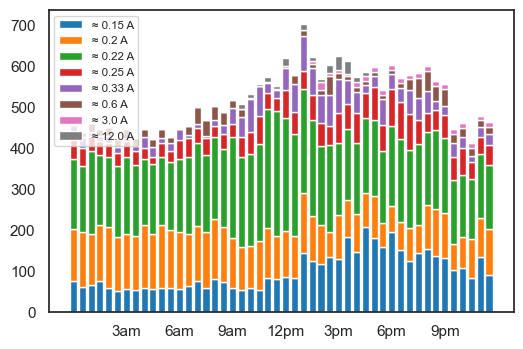

In [13]:
def currentsStackedBarChart(data, bucketsColumn="timeOfDayBuckets2", catLabels=None, legLoc="upper left", matchEnds=True, ylim=None):

    currentBucketCounts, allBuckets = getGroupedCurrents(data, bucketsColumn, matchEnds=matchEnds)

    stackedDataPlot = list(map(list, zip(*currentBucketCounts)))
    #catLabels = ["." for x in range(len(stackedDataPlot[0]))]
    if not catLabels:
        catLabels = ["", "", "", "", "", "", "3am", "", "", "", "", "", "6am", "", "", "", "", "", "9am", "", "", "", "", "", "12pm", "", "", "", "", "", "3pm", "", "", "", "", "", "6pm", "", "", "", "", "", "9pm", "", "", "", "", ""]
    serLabels = ["≈ " + str(x) + " A" for x in allBuckets]
    plot_stacked_bar(stackedDataPlot,
                     series_labels=serLabels,
                     category_labels=catLabels,
                     colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'],
                     title="Amps",
                     legLoc=legLoc,
                     ylim=ylim)

currentsStackedBarChart(usedData)

In the above graph, a stacked bar graph is used to illustrate the different times that different currents are used. Clearly the larger current draws are very rare and most of the time the HLH is using less than 0.25A when being used. There seems to be a fairly consistent draw of ≈0.22A to ≈0.25A usage during the day, with ≈0.2A being more common in the morning, switching over to ≈0.15A in the evening. The values higher than ≈0.3A are too inconsistent to note any substantial trends from in this graph. 

In [14]:
usedData["weekDay"] = usedData["Datetime"].apply(lambda x: x.isoweekday())
usedData[usedData["weekDay"] == 7]

c:\users\baptiste\envs\smartpowerdata\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Datetime,AC Current,timeOfDay,timeOfDayBuckets,currentBuckets,timeOfDayBuckets2,weekDay
3540,2019-03-24 00:00:00,0.259,0.000000,0.000000,0.263027,0.0,7
3541,2019-03-24 00:01:30,0.244,0.025000,0.000000,0.239883,0.0,7
3542,2019-03-24 00:03:00,0.234,0.050000,0.083333,0.229087,0.0,7
3543,2019-03-24 00:04:30,0.259,0.075000,0.083333,0.263027,0.0,7
3544,2019-03-24 00:06:00,0.244,0.100000,0.083333,0.239883,0.0,7
...,...,...,...,...,...,...,...
117737,2019-10-06 16:17:00,0.190,16.283333,16.250000,0.190546,16.5,7
117738,2019-10-06 16:18:30,0.186,16.308333,16.333333,0.181970,16.5,7
117739,2019-10-06 16:20:00,0.181,16.333333,16.333333,0.181970,16.5,7
117740,2019-10-06 16:21:30,0.176,16.358333,16.333333,0.173780,16.5,7


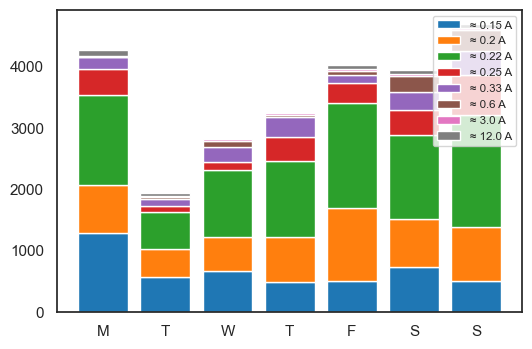

In [15]:
currentsStackedBarChart(usedData, bucketsColumn="weekDay", catLabels=["M", "T", "W", "T", "F", "S", "S"], legLoc="upper right", matchEnds=False)

Looking at the current splits on a weekly basis rather than half-hourly, we can see that generally weekdays have a similar ratio of power usages, with Friday having a larger than usual percentage of ≈0.2A current usage. The most unusual piece of information we can see in this is that there is a significant drop in activity from Monday to Tuesday, and then a slow crawl up from Tuesday onwards.

Text(0.5, 1.0, 'Total datapoint weekday distribution')

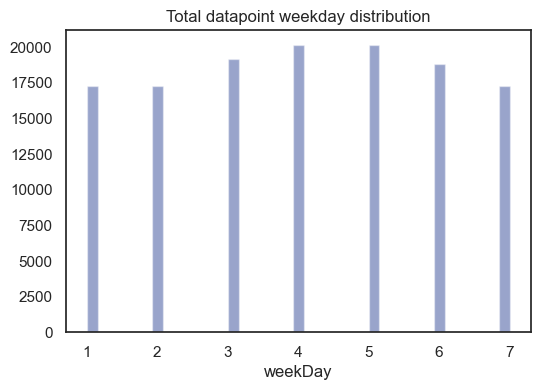

In [16]:
MSQdata_all["weekDay"] = MSQdata_all["Datetime"].apply(lambda x: x.isoweekday())
ax = sns.distplot(MSQdata_all["weekDay"], kde=False)
ax.set_title("Total datapoint weekday distribution")

Given the above data, we can see that the spread of recorded information is fairly consistent, with a small swell at Thursday/Friday, so the increase of activity from Tuesday to Monday and then the drop off back to Tuesday is not just due to an increase in recorded information

                                Monday


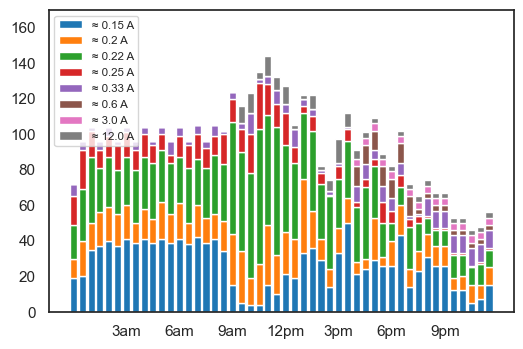

In [17]:
currentsStackedBarChart(usedData[usedData["weekDay"] == 1], ylim=(0,170))
print("                                Monday")

                                Tuesday


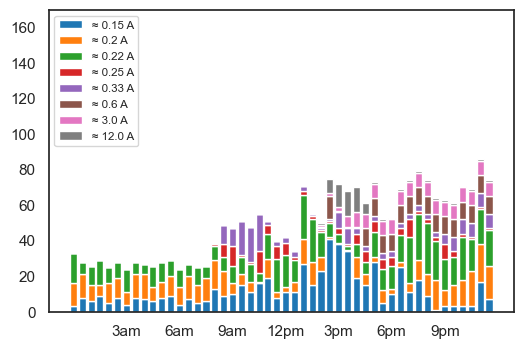

In [18]:
currentsStackedBarChart(usedData[usedData["weekDay"] == 2], ylim=(0,170))
print("                                Tuesday")

                                Wednesday


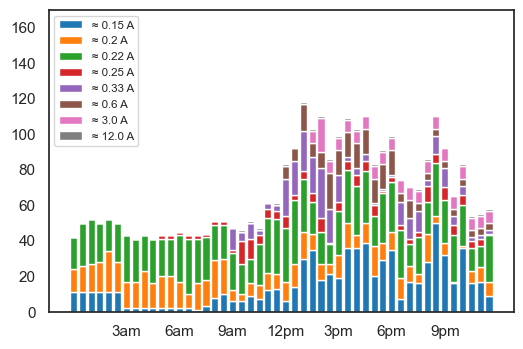

In [19]:
currentsStackedBarChart(usedData[usedData["weekDay"] == 3], ylim=(0,170))
print("                                Wednesday")

                                Thursday


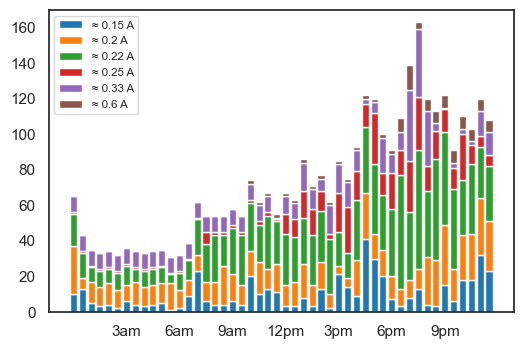

In [20]:
currentsStackedBarChart(usedData[usedData["weekDay"] == 4], ylim=(0,170))
print("                                Thursday")

                                Friday


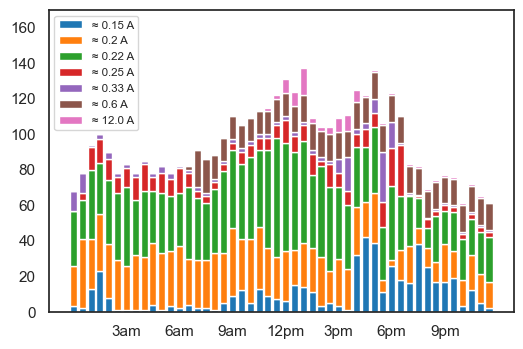

In [21]:
currentsStackedBarChart(usedData[usedData["weekDay"] == 5], ylim=(0,170))
print("                                Friday")

                                Saturday


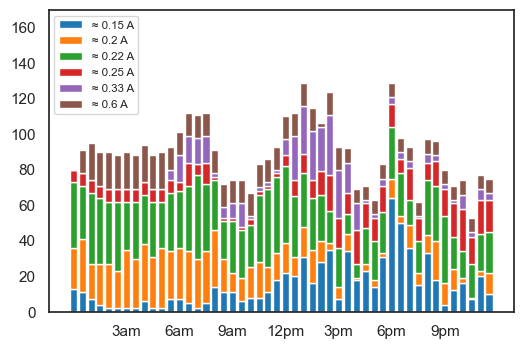

In [22]:
currentsStackedBarChart(usedData[usedData["weekDay"] == 6], ylim=(0,170))
print("                                Saturday")

                                Sunday


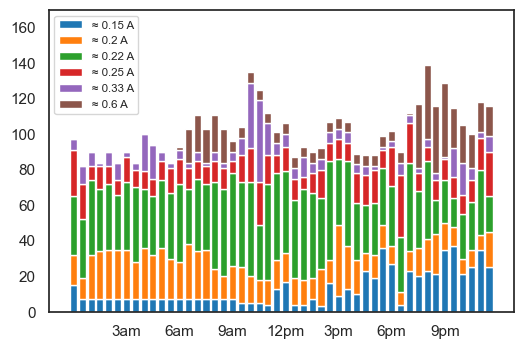

In [23]:
currentsStackedBarChart(usedData[usedData["weekDay"] == 7], ylim=(0,170))
print("                                Sunday")

Looking at each of the days of the week more in depth we can see that from Tuesday-Thursday there isn't as much usage in the morning, whereas Friday-Monday have consistent usage even during the middle of the night. This may be due to lighting settings that are on for these days, as Thursday-Sunday nights are potentially more likely to have activity. It may also be due to people turning these lights on because they are in these areas at this time.

Another thing to note is that higher current usages are more likely to be observed later in the day. This may be evidence that people are using the HLH poles to power and charge things moreso during the evening such as phones, laptops, bluetooth speakers, and so on. It's difficult to say what is being used as a lot of appliances use very similar (low) current draws, especially those that are likely to be plugged in here. For example, a toaster or air conditioning unit may have a much higher current draw but are unlikely to be plugged into the HLH pole.

In [24]:
times = list(list(usedData["Datetime"]))
type((times[1] - times[0]).total_seconds())

float

c:\users\baptiste\envs\smartpowerdata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\baptiste\envs\smartpowerdata\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\baptiste\envs\smartpowerdata\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

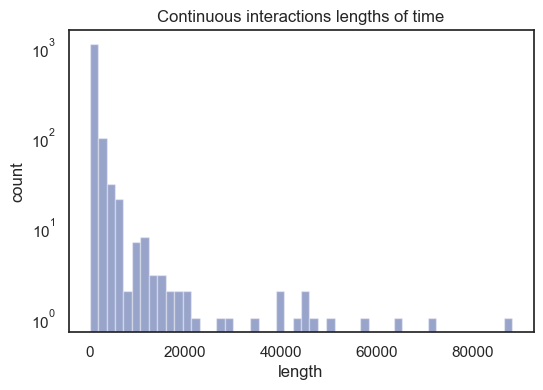

In [25]:
# Calculating timegaps between entries
usedData["nextTime"] = usedData["Datetime"].shift(1)
usedData["timeGap"] = (usedData["Datetime"] - usedData["nextTime"])
usedData["timeGap"] = usedData["timeGap"].apply(lambda x: x.total_seconds())

def acceptableVariation(prevCurrent, current):
    """Return whether the new current is acceptably close to the previous to be considered the same usage"""
    return abs(1-current/prevCurrent) < 0.15


# initialising variables for the following loop
prevCurrent = 999999
entryCount = 0
continuousUsageList = []

# Looping through rows to calculate series of consistent entries (sustained usage by an individual)
for row in usedData.itertuples():
    current = row[2]
    timeGap = row[9]
    # Ensuring concurrent times (time gaps should be time%90 = 0)
    if timeGap < 100 and acceptableVariation(prevCurrent, current):
        prevCurrent = (prevCurrent + current)/2
        entryCount += 1
    else:
        # Making sure that acceptable variation would not have included values below the cut-off
        if not acceptableVariation(0.135, prevCurrent):
            # Entering found values
            continuousUsageList.append({"current": prevCurrent, "length": 90*entryCount})

        # Initialising values for next series
        prevCurrent = current
        entryCount = 1

# Entering last found values
continuousUsageList.append({"current": prevCurrent, "length": 90*entryCount})
continuousUsageList = continuousUsageList[1:]
continuousUsageData = pd.DataFrame(continuousUsageList)
#ax = sns.kdeplot(continuousUsageData["current"], continuousUsageData["length"], shade=True)
#ax.set_yscale('log')
#ax.set_xscale('log')

#continuousUsageData["length"].sum()

ax = sns.distplot(continuousUsageData["length"], kde=False)
ax.set_title("Continuous interactions lengths of time")
ax.set_ylabel("count")
ax.set_yscale('log')

The above graph demonstrates that most interactions have quite a short length, with a few exceptions, such as the 24.5hr long interaction outlier (88200 seconds). The downside to this data really though is the 90-second interval used for recording, which makes suggesting the actual length of an interaction difficult if it less than 3 interactions, or 270 seconds.

If we zoom in however, we can understand in better detail what lengths are occuring.

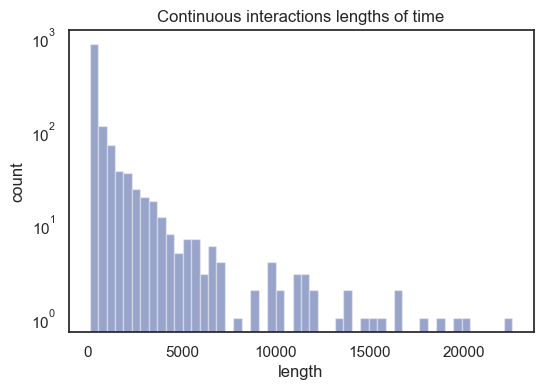

In [26]:
ax = sns.distplot(continuousUsageData[continuousUsageData["length"] < 25000]["length"], kde=False)
ax.set_title("Continuous interactions lengths of time")
ax.set_ylabel("count")
ax.set_yscale('log')

And if we zoom in again...

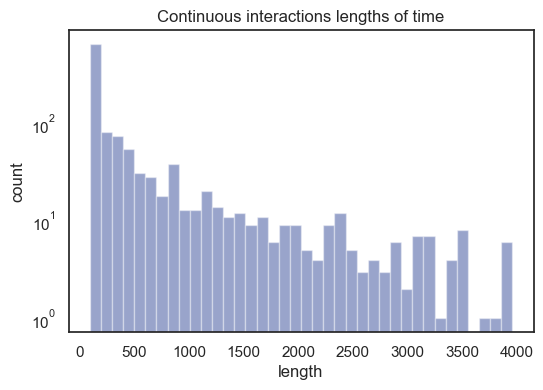

In [27]:
ax = sns.distplot(continuousUsageData[continuousUsageData["length"] < 4000]["length"], kde=False)
ax.set_title("Continuous interactions lengths of time")
ax.set_ylabel("count")
ax.set_yscale('log')

We can see that there is still a spread of lengths at the lower end of time lengths.

In [28]:
averageLength = (continuousUsageData["length"].sum()/90)/len(continuousUsageData)*90
medianLength = continuousUsageData["length"].median()

print("Average length: " + str(averageLength))
print("Median length: " + str(medianLength))

Average length: 1541.8495297805641
Median length: 180.0


As seen above, the average length is considerably higher than the median length⁠—this is because of some very large outliers, such as the 24.5hr length observed earlier. According to these processes, there's about a 70% chance that someone will use the HLH for less than 10 minutes.

However, this includes some substantial caveats. Overall, it is difficult to tell when a current corresponds to a particular device being used, due to differences in current draws even within the one device (which I came to the conclusion of after some googling & talking to electrical engineers). This can be demonstrated by the draw of the laptop in the test data. Also, if a particular use of one device was uninterrupted but another user began or stopped drawing current, it would be counted as a different device.

Further research into this area is required for better results. A potentially better method would include extensive testing and recording of current draws by a variety of appliances, which is then fed into an ML classifier to train it.

In [29]:
print("Full length results:\n")

for result in continuousUsageData.groupby("length").count().itertuples():
    print(str(result[1]) + " results of " + str(result[0]) + " seconds")

Full length results:

459 results of 90 seconds
189 results of 180 seconds
81 results of 270 seconds
74 results of 360 seconds
55 results of 450 seconds
31 results of 540 seconds
28 results of 630 seconds
18 results of 720 seconds
21 results of 810 seconds
17 results of 900 seconds
13 results of 990 seconds
13 results of 1080 seconds
20 results of 1170 seconds
14 results of 1260 seconds
11 results of 1350 seconds
12 results of 1440 seconds
9 results of 1530 seconds
7 results of 1620 seconds
4 results of 1710 seconds
6 results of 1800 seconds
9 results of 1890 seconds
9 results of 1980 seconds
5 results of 2070 seconds
4 results of 2160 seconds
9 results of 2250 seconds
7 results of 2340 seconds
5 results of 2430 seconds
5 results of 2520 seconds
3 results of 2610 seconds
4 results of 2700 seconds
3 results of 2790 seconds
6 results of 2880 seconds
2 results of 2970 seconds
7 results of 3060 seconds
2 results of 3150 seconds
5 results of 3240 seconds
1 results of 3330 seconds
4 results 

Text(0.5, 1.0, 'Current draw frequency plotted against length frequency')

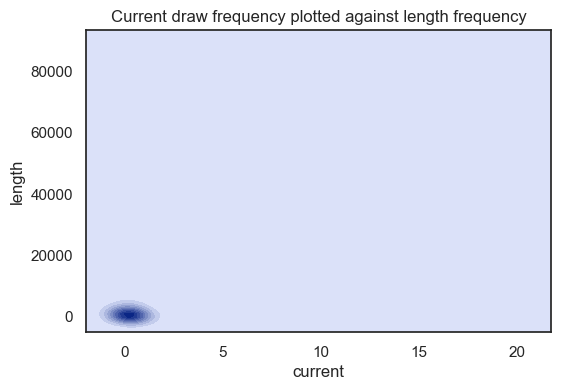

In [30]:
ax = sns.kdeplot(continuousUsageData["current"], continuousUsageData["length"], shade=True)
ax.set_title("Current draw frequency plotted against length frequency")
#ax.set_yscale('log')
#ax.set_xscale('log')


Text(0, 0.5, 'length (log base 10)')

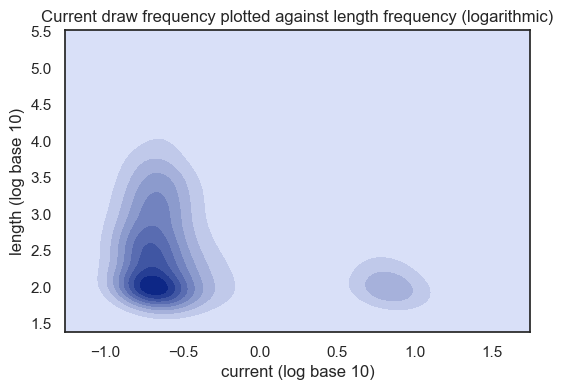

In [31]:
logCurrents = continuousUsageData["current"].apply(lambda x: math.log10(x))
logLengths = continuousUsageData["length"].apply(lambda x: math.log10(x))
ax = sns.kdeplot(logCurrents, logLengths, shade=True)
ax.set_title("Current draw frequency plotted against length frequency (logarithmic)")
ax.set_xlabel("current (log base 10)")
ax.set_ylabel("length (log base 10)")